<h2>Les données

L'objectif de ce TP est d'implémenter une validation croisée

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('winequality-white.csv', sep=";")
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

Nos données contiennent 11 colonnes, 10 qui correspondent à divers indicateurs physico-chimiques et 1 qui est la qualité du vin.

Nous allons extraire deux arrays numpy de ces données, un qui contient les points et l’autre qui contient les étiquettes

In [20]:
X = data[data.columns[:-1]].values
y = data['quality'].values

On peut maintenant afficher un histogramme pour chacune de nos variables :

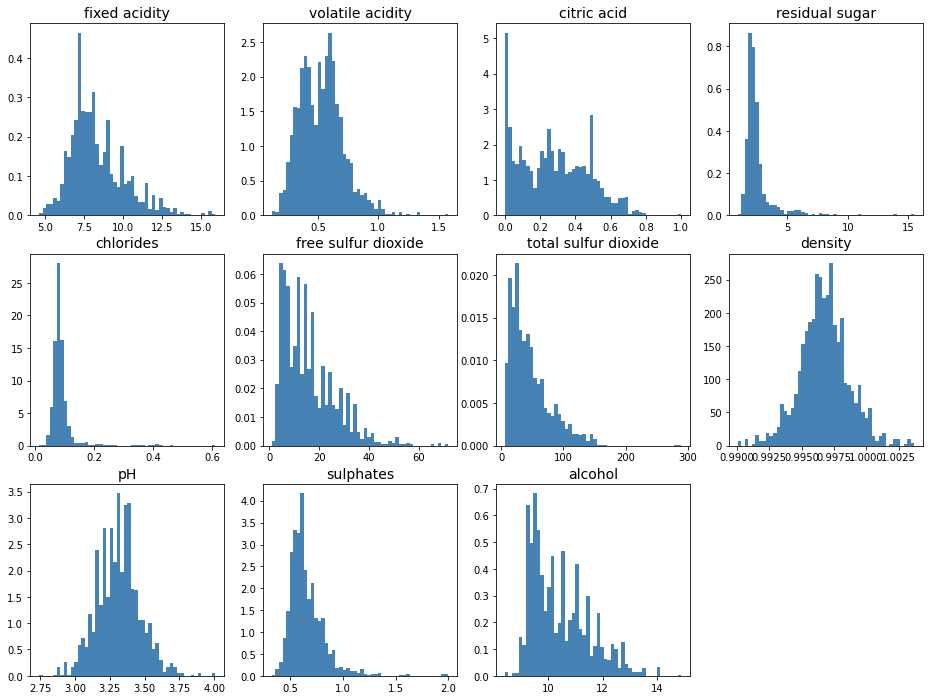

In [21]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

<h2>Selection de modèle

Nous allons commencer par transformer ce problème en un problème de classification : il s’agira de séparer les bons vins des vins médiocres :

In [22]:
y_class = np.where(y<6, 0, 1)

In [23]:
y_class

array([0, 0, 0, ..., 1, 0, 1])

Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 30% des données.

In [24]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class,test_size=0.3) # 30% des données dans le jeu de test

Nous pouvons maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

In [25]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

On peut visualiser de nouveau les données pour vérifier que les différentes variables prennent des valeurs qui ont maintenant des ordres de grandewur similaires.

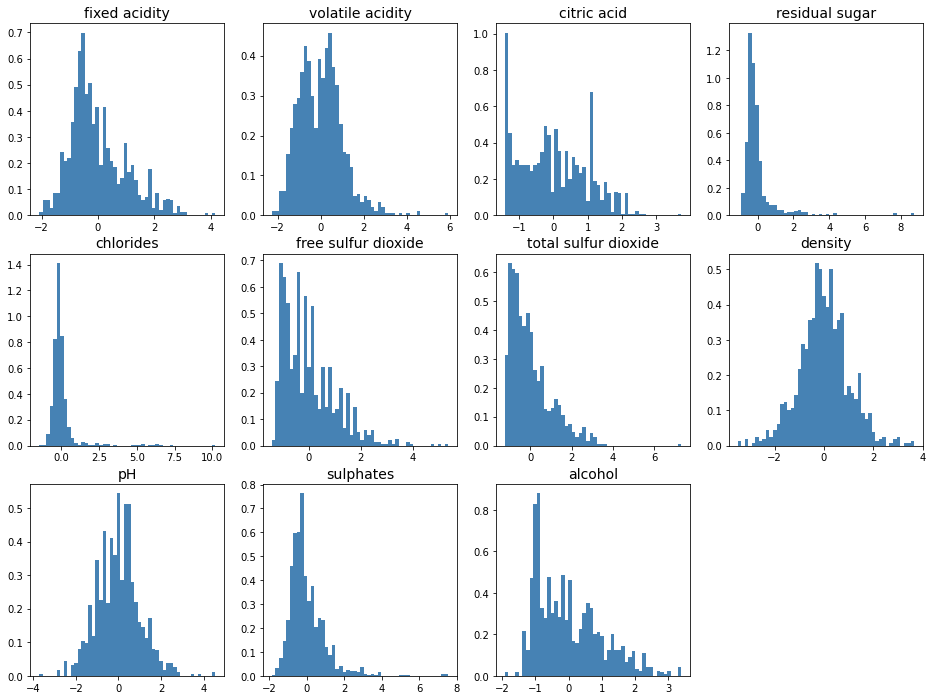

In [26]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

Nous allons maintenant utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [27]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 5}
Résultats de la validation croisée :
accuracy = 0.706 (+/-0.072) for {'n_neighbors': 3}
accuracy = 0.719 (+/-0.077) for {'n_neighbors': 5}
accuracy = 0.710 (+/-0.086) for {'n_neighbors': 7}
accuracy = 0.718 (+/-0.070) for {'n_neighbors': 9}
accuracy = 0.715 (+/-0.088) for {'n_neighbors': 11}
accuracy = 0.714 (+/-0.086) for {'n_neighbors': 13}
accuracy = 0.716 (+/-0.085) for {'n_neighbors': 15}


La meilleure performance (~0.718) est ici atteinte avec 9 voisins.

Nous pouvons maintenant regarder la performance sur le jeu de test. GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement,

In [28]:
y_pred = clf.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))



Sur le jeu de test : 0.733
